In [1]:
import json
import uncertainties
import numpy as np
from uncertainties import ufloat
from uncertainties import unumpy as unp
import glob
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
data=glob.glob('DATA/*.json*')
data_sorted=sorted(data,key=lambda x: (x.count('eta'),x.count('3p'),x.count('SS')))
data=[pd.read_json(f) for f in data_sorted]
selections={'pt_1p':data[0:2],'pt_3p':data[2:4],'eta_1p':data[4:6], 'eta_3p':data[6:]}

# TAU MISIDENTIFICATION PROBABILITY (mip) NOMINAL VALUE

Before calculating the confidence interval, let's evaluate the nominal value for the mip.

In [3]:
# Here we are assuming to deal with poissonian statistics so that the error we associate to each bin entries
# is the square root of the entries.

def bin_statistics(bin_entries):
    
    'Take the number of entries in each bin and return the number of entries with an error associated to it '
    
    array = unp.uarray(bin_entries, np.sqrt(bin_entries)) #poissonian statistics for the bin entries in each bin
    
    return array

mip=unp.uarray(np.empty(4),np.empty(4))

for i in range(0,8,2):
    
    ttbar_os= bin_statistics(data[i].loc['curve','ttbar'])
    
    ttbar_ss=bin_statistics(data[i+1].loc['curve','ttbar'])
    
    mip[int(i/2)]=(ttbar_ss/(ttbar_os+ttbar_ss)).mean()
    
dict_mip = {'pt_1p':str(mip[0]*100), 'pt_3p':str(mip[1]*100),'eta_1p':str(mip[2]*100), 'eta_3p':str(mip[3]*100)}

dict_mip

{'pt_1p': '4.63+/-0.29',
 'pt_3p': '5.9+/-0.6',
 'eta_1p': '9.3+/-0.5',
 'eta_3p': '2.9+/-0.4'}

# VISUALIZING THE mip 

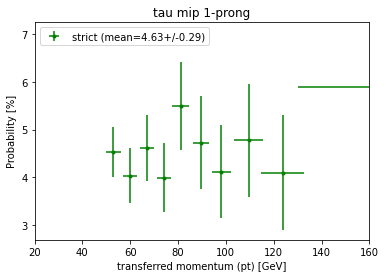

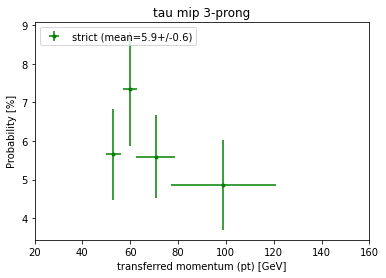

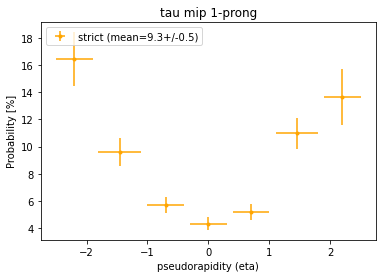

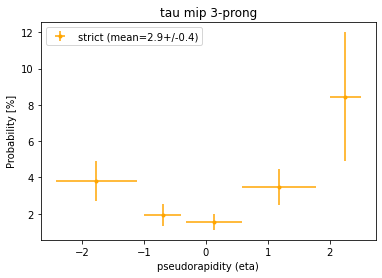

In [4]:
def plot(variable):
    
    newbins=[]
    newflip=[]
    bin_widths=[]
  
    bins=pd.DataFrame(selections[variable][0].loc['bins','metadata']) #transforms list to pandas dataframe
    
    #bin_centers=unumpy.umatrix((np.matrix(bins[1:])+np.matrix(bins[:-1]))/2,(np.matrix(bins[1:])-np.matrix(bins[:-1]))/2)
    entries_os=unp.umatrix(selections[variable][0].loc['curve','ttbar'],np.sqrt(selections[variable][0].loc['curve','ttbar']))
    entries_ss=unp.umatrix(selections[variable][1].loc['curve','ttbar'],np.sqrt(selections[variable][1].loc['curve','ttbar']))
  
    flip=entries_ss/(entries_ss+entries_os)*100
        
    ########## BINNING OF 10 #############################################################################
    n=7 #number points included in one bin
        
    for j in range(0,len(bins)-1,n):
        
        #newbins.append(bin_centers[j:j+n].mean())
        newbins.append(bins[j:j+n].mean())
        newflip.append(flip[0,j:j+n].mean()) #the shape of flip is (1,len(bins)-1) 
        bin_widths.append((np.amax(bins.iloc[j:j+n])-np.amin(bins.iloc[j:j+n]))/2)
            
    newflip_mean=flip.mean()#np.matrix(newflip).mean()
        
    ############ PLOT ######################################################################################
        
      #label for the plot
        
    label_name='strict'+' (mean=' + str(newflip_mean) + ')'
    
    #setting x scale
        
    if 'pt_' in variable:
        plt.xlabel('transferred momentum (pt) [GeV]')
        plt.xlim(20,160)
        colour='green'
    else:
        plt.xlabel('pseudorapidity (eta)')
        colour='orange'
        
      #setting title
        
    if '_1p' in variable:
         plt.title('tau mip 1-prong')
    else:
         plt.title('tau mip 3-prong')
            
        
    plt.errorbar(unp.nominal_values(newbins),unp.nominal_values(newflip),yerr=unp.std_devs(newflip).reshape(-1),xerr=np.array(bin_widths).reshape(-1),fmt='.',label=label_name,c=colour)
        
    plt.ylabel('Probability [%]')
    plt.legend(loc='upper left')
        
    plt.savefig(variable+'.pdf')
    return(plt.show())
        
for key,value in selections.items():plot(key)
    

# CONFIDENCE INTERVALS WITH BOOTSTRAP METHOD

This method exploits the np.random(data,len(data)) Python function for generating a simulated pdf starting from the original input pdf (data).

In [5]:
def bootstrap_replicate_1d(data):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return bs_sample 

## The strategy
1. first we have to take the fake pdf and use the bootstrap method to produce a lot of simulated fake pdfs. 

In [6]:
def simulated_population(bins,entries,total,size):
    
    'Takes in the real fake distribution and generate multiple simulated ttbar pdfs'
    
    #bins = np.array(bins)
    
    #entries = np.array(entries)
    
    #total = np.array(total)
    
    bin_centers=(bins[1:]+bins[:-1])/2
    
    ttbar_population = []
    
    sample = []
    
    for i,j in enumerate(entries):
        
        for m in range(0,int(j)):
            
            sample.append(bin_centers[i])
    
    t0 = time.time()
    
    for n in range(0,size):
        
        ttbar_population.append(total - np.histogram(bootstrap_replicate_1d(sample),bins)[0])
        
    tf = time.time() - t0
        
    return np.array(ttbar_population), tf
        

2. Once we have the code for generating  multiple fake pdfs, we use them to get multiple simulated ttbar pdfs 
   subtracting from the total number of event (fake+ttbar) the simulated fakes.
   We apply the procedure both for opposit sign and same sign region. Then we calculate the mip in each bin
   by dividing the number of same sign ttbar events that fall into the bin by the total number of event in the bin 
   (same sign + opposit sign). So we get a mip estimate for each bin and we the take the overall mean.
   
   The whole procedure has to be repeated for both transferred momentum and pseudorapidity variables and for
   1-prong and 3-prong kind of event

In [7]:
mip_pdf = {}

t = 0

for key,value in selections.items():
    
    size = 10000
    
    mip_pdf[key] = np.empty(size)
    
    bins = np.array(selections[key][0].loc['bins','metadata'])
    
    fakes_os = np.array(selections[key][0].loc['curve','fakes'])
    
    fakes_ss = np.array(selections[key][1].loc['curve','fakes'])
    
    total_os = fakes_os + np.array(selections[key][0].loc['curve','ttbar'])
    
    total_ss = fakes_ss + np.array(selections[key][1].loc['curve','ttbar'])
    
    ttbar_os_population = simulated_population(bins,fakes_os,total_os,size)[0]
    
    ttbar_ss_population = simulated_population(bins,fakes_ss,total_ss,size)[0]
    
    t = simulated_population(bins,fakes_os,total_os,size)[1] + simulated_population(bins,fakes_ss,total_ss,size)[1] + t
    
    for j in range(0,size):
    
        mip_pdf[key][j] = (ttbar_ss_population/(ttbar_ss_population+ttbar_os_population))[j].mean()
        
print('Time for bootstrap method to produce '+str(size*8)+' fake pdfs is '+str(t)+' s')

Time for bootstrap method to produce 80000 fake pdfs is 17.19862198829651 s


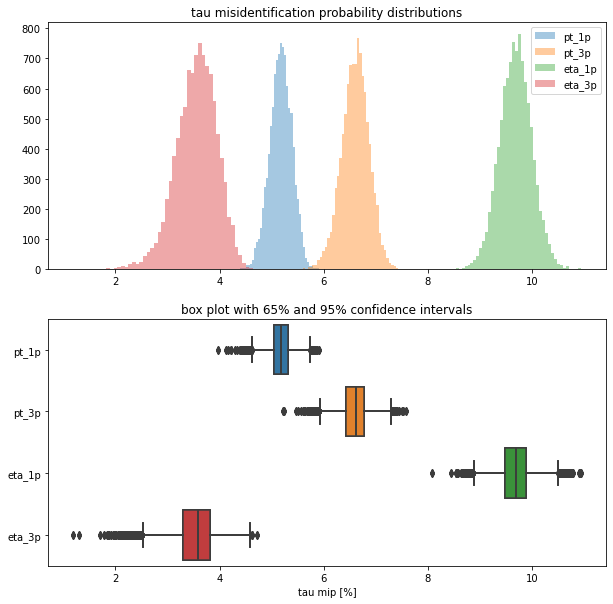

In [8]:
f, axes = plt.subplots(2, 1, figsize=(10, 10))

for key,value in mip_pdf.items():
    sns.distplot(mip_pdf[key]*100, kde=False, ax=axes[0],label=str(key))
    sns.boxplot(data=pd.DataFrame.from_dict(mip_pdf, orient='columns')*100, orient="h",ax=axes[1])

axes[0].set(title='tau misidentification probability distributions')
axes[1].set(xlabel='tau mip [%]',title='box plot with 65% and 95% confidence intervals')
axes[0].legend()

## CONFIDENCE INTERVAL

  event type  |  mean value [%]  |    confidence intervals   |
--------------|-----------------|-------|
 pt (1 prong) |  $5.17$| $[4.72,5.57]$|
 pt (3 prong) |  $6.60 $|   $[6.06, 7.10]$|
 eta (1 prong)|  $9.69 $|    $[ 9.08, 10.29]$|
 eta (3 prong)|  $3.56 $|      $[2.70, 4.22]$ |

# CONFIDENCE INTERVALS WITH MACHINE LEARNING REGRESSION METHODS

Another way to attach the problem is to try to fit the experimental fake pdf with regression methods which exploit machine learning. The curve that comes out from the fit is then used to generated a lot of fake pdfs and eventually the procedure to calculate the mip is identical to that of bootstrap showed above.

## 1. K Nearest Neighbors (KNN) Regression Method

This method of regrassion considers a point of th training sample and and its k nearest neighbors and try to understand locally the trend of the function. To see how this work, let's consider one oh the fake pdf of the dataset. First of all, we divide the points of the pdf in two sets: one is used to fit and the other one to score the quality of the fit.

The sample used to validate the quality of the fit may have some peculiarity, that is, the R-squared calculated on it may not be representative of the model ability to generalize unseen data. To overcome this problem we use a tecnique called **cross validation**. Let's say that we split the data in 5 folds and use, in turn, 4 of them to fit the data and 1 to test the prediction of the fit. In this way we have 5 different scores from which we can calculate the mean and get a better feedback about the fit performance.

The number of folds one decides sto split the data is completely arbitrary (in this case 5 fold cross-validation) wherease the number of neighbors can be choosen to have the best score without overfitting the data. 

KNN Regressor score : 0.7105150374748719 with training sample of size 28


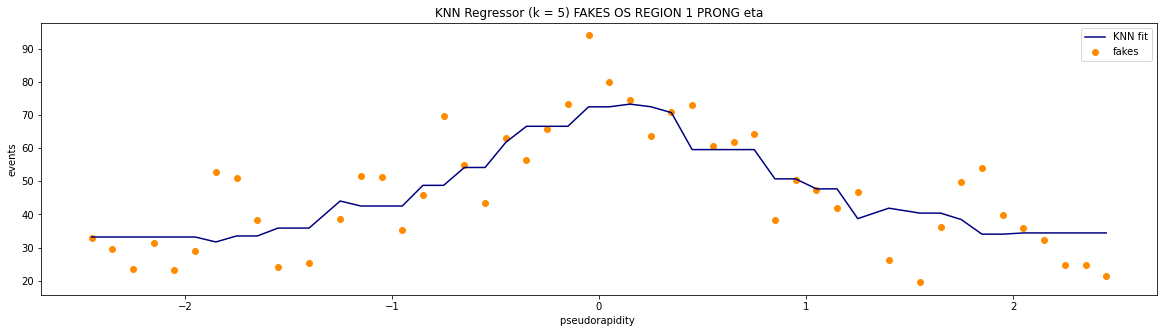

In [9]:
y = np.array(selections['eta_1p'][0].loc['curve','fakes']).reshape(-1)

bins = np.array(selections['eta_1p'][0].loc['bins','metadata'])

X = ((bins[1:]+bins[:-1])/2).reshape(-1,1)

n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

y_ = knn.fit(X_train, y_train).predict(X)

plt.figure(figsize=(20,5))
plt.scatter(X, y, color='darkorange', label='fakes')
plt.plot(X, y_, color='navy', label='KNN fit')
plt.xlabel('pseudorapidity ')
plt.ylabel('events')
plt.axis('tight')
plt.legend()
plt.title("KNN Regressor (k = %i) FAKES OS REGION 1 PRONG eta" % (n_neighbors))

cv_scores = cross_val_score(knn, X, y, cv=5) # 5 fold cross-validation

print('KNN Regressor score : '+ str(-cv_scores.mean())+' with training sample of size '+str(len(X_train)))

# 2. Decision Tree Regression method

A decision tree is a supervised machine learning model used to predict a target by learning decision rules from features. As the name suggests, we can think of this model as breaking down our data by making a decision based on asking a series of questions. The order of the question as well as their content are being determined by the model. In addition, the questions asked  are all in a True/False form.

To fully determine our model we need to specify the max_depth parameter, namely the max depth of the tree. Let's see how this method works on the same fake sample we've used above.

The simple DT regressor can be combined with the ADABoost method,that here will not be treated

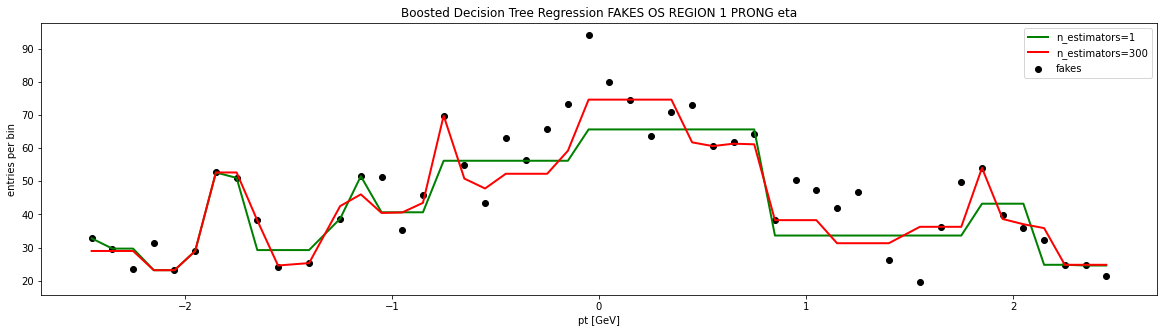

DT Regressor with max_depth=4 : 1.4230555740695459 and with the addition of AdaBoost 0.9128737870448298


In [10]:
rng = np.random.RandomState(1)

regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=rng)

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.4, random_state=rng)

regr_1.fit(X_train, y_train)

regr_2.fit(X_train, y_train)

y_1 = regr_1.predict(X)

y_2 = regr_2.predict(X)

# Plot the results
plt.figure(figsize=(20,5))
plt.scatter(X, y, c="k", label="fakes")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("pt [GeV]")
plt.ylabel("entries per bin")
plt.title("Boosted Decision Tree Regression FAKES OS REGION 1 PRONG eta")
plt.legend()
plt.show()

cv_scores1 = cross_val_score(regr_1, X, y, cv=5)

cv_scores2 = cross_val_score(regr_2,X, y, cv=5)

print('DT Regressor with max_depth=4 : '+ str(-cv_scores1.mean())+ ' and with the addition of AdaBoost '+str(-cv_scores2.mean()))

In this case we have an example of overfitting, indeed the obtained score of the only DT Regressor is larger than 1. To avoid overfitting, we will then use the GridSearch function and, moreover, we:

- split data into training and hold-out set at the beginning

- perform grid search cross-validation on training set

- Choose best hyperparameters on the training set and evaluate on hold-out set

## The choice of the best parameter defining the model

In [11]:
def best_param_DT(X,y):
    
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)
    
    param_grid= {'max_depth' : np.arange(2,50)}
   
    DT = DecisionTreeRegressor()
    
    DT_cv = GridSearchCV(DT, param_grid, cv=5)
    
    DT_cv.fit(X_train,y_train)
    
    return DT_cv.best_params_['max_depth']

def best_param_ADA(X,y,depth):
    
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)
    
    param_grid= {'n_estimators' : np.arange(250,350)}
    
    ADA = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth))
    
    ADA_cv = GridSearchCV(ADA, param_grid, cv=5)
    
    ADA_cv.fit(X_train,y_train)
    
    return ADA_cv.best_params_['n_estimators']

def best_param_KNN(X,y):
    
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)
    
    param_grid= {'n_neighbors' : np.arange(1,7)}
   
    KNN =  neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
    
    KNN_cv = GridSearchCV(KNN, param_grid, cv=5)
    
    KNN_cv.fit(X_train,y_train)
    
    return KNN_cv.best_params_['n_neighbors']
    
    

In [13]:
best_depth, best_neighbors = ([] for i in range(0,2))

for key, value in selections.items():
    
    for i in range(0,2):
    
        y = np.array(selections[key][i].loc['curve','fakes']).reshape(-1)

        bins = np.array(selections[key][i].loc['bins','metadata'])

        X = ((bins[1:]+bins[:-1])/2).reshape(-1,1)
        
        best_depth.append(best_param_DT(X,y))
        
        best_neighbors.append(best_param_KNN(X,y))
        
best_depth,best_neighbors

([3, 3, 3, 2, 2, 2, 3, 2], [4, 6, 3, 3, 6, 6, 5, 5])

## The strategy

In the following we will generate multiple fake distributions by using both DT(with ADA boost) and KNN methods in order to compare the two methods. 

The model works as follow:

- take the fake distribution;

- split the sample into train and test samples;

- take the train sample and choose the best parameter defining the model for the fit (the choice is the output of
  one of the functions defined above);
   
- fit the training set and score the performance with the test set by using the **R squared value**;

- from the fit generate multiple fake distributions and then calculate the mip confidence intervals.

In [14]:
def Regressor(strategy, X, y, total, size, parameter):
    
    X = X.reshape(-1,1)
    
    y = y.reshape(-1)
    
    total = total.reshape(-1) 
    
    rng = np.random.RandomState(1)
    
    score,population = ([] for i in range(0,2))
    
    if strategy=='ADA':
        
        DT = DecisionTreeRegressor(max_depth=parameter)
        
        regr = AdaBoostRegressor(DT,n_estimators=300, random_state=rng)
        
    if strategy=='DT':
        
        regr = DecisionTreeRegressor(max_depth=parameter)
        
    elif strategy=='KNN':
        
        regr = neighbors.KNeighborsRegressor(n_neighbors=parameter, weights='uniform')
        
    t0 = time.time()
    
    for i in range(0,size):
        
        X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.4, random_state=rng)
    
        regr.fit(X_train, y_train)
    
        score.append(r2_score(y_test,regr.predict(X_test)))
        
        population.append(total - regr.predict(X).reshape(-1)) #list containing multiple pdfs
        
    mean_score = np.mean(score)
    
    tf=time.time()-t0
    
    return population, mean_score, tf

In [15]:
def Simulation(strategy, size):
   
    scores = {}
    
    best_param_ ={'KNN': best_param_KNN, 'DT': best_param_DT}
    
    mip_pdf={'pt_1p':np.empty(size),'pt_3p':np.empty(size),'eta_1p':np.empty(size),'eta_3p':np.empty(size)}
    
    for key, value in selections.items():
       
        bins = np.array(selections[key][0].loc['bins','metadata'])
    
        X = ((bins[1:]+bins[:-1])/2)
        
        fakes_os, fakes_ss = (np.array(selections[key][i].loc['curve','fakes']) for i in range(0,2))
    
        total_os, total_ss = (np.array(selections[key][i].loc['curve','fakes']) + np.array(selections[key][i].loc['curve','ttbar']) for i in range(0,2)) 
    
        parameter_os, parameter_ss = (best_param_[strategy](X.reshape(-1,1),y.reshape(-1)) for y in [fakes_os,fakes_ss])
            
        new_ttbar_os = np.array(Regressor(strategy, X, fakes_os, total_os, size, parameter_os)[0]) #set of 10000 sample of simulated ttbar os pdfs
    
        new_ttbar_ss = np.array(Regressor(strategy, X, fakes_ss, total_ss, size, parameter_ss)[0])
            
        mip_pdf[key] = [j.mean() for i,j in enumerate(new_ttbar_ss/(new_ttbar_ss+new_ttbar_os))]
        
        scores[key] = (Regressor(strategy, X, fakes_os, total_os, size, parameter_os)[1]+Regressor(strategy, X, fakes_ss, total_ss, size, parameter_ss)[1])/2

    return mip_pdf, scores

If one wants to get a consistent estimate of the confidence intervals then should generate a lot of fake pdfs, let's say 10000. Playing a bit with the code written above, one sees that a strategy involving ADABoost is very time consuming and the score is not so far from the one generate with only Decision Tree regressor, so in the following we'd better compare KNN and DT strategy. 

In [45]:
knn,dt = (Simulation(i,10000) for i in ['KNN','DT'])

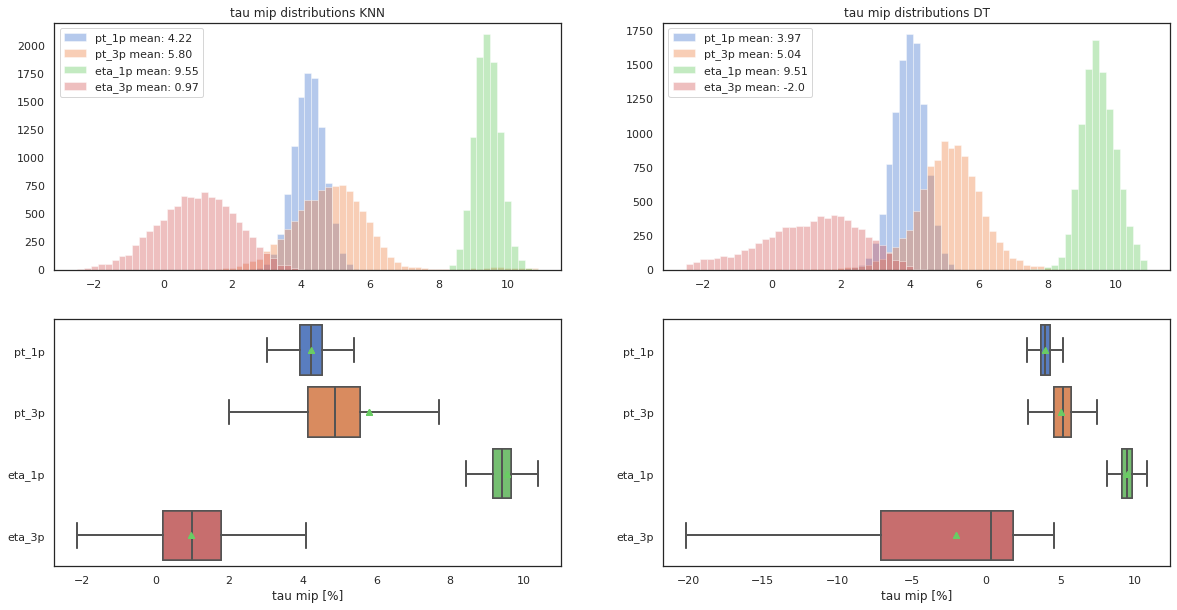

In [46]:
f, axes = plt.subplots(2, 2, figsize=(20, 10))#, sharex=True)
bins=np.arange(-2.5,11,0.2)


for i,key in enumerate(['pt_1p','pt_3p','eta_1p','eta_3p']):

    sns.distplot(np.array(knn[0][key])*100, bins=bins, kde=False, ax=axes[0, 0], label=key+' mean: '+str(np.mean(knn[0][key])*100)[:4])
    sns.distplot(np.array(dt[0][key])*100, bins=bins, kde=False, ax=axes[0, 1], label=key+' mean: '+str(np.mean(dt[0][key])*100)[:4])
    sns.boxplot(data=pd.DataFrame.from_dict(knn[0], orient='columns')*100, orient="h",ax=axes[1,0],showfliers=False,showmeans=True)
    sns.boxplot(data=pd.DataFrame.from_dict(dt[0], orient='columns')*100, orient="h",ax=axes[1,1],showfliers=False,showmeans=True)

axes[0,0].set(title='tau mip distributions KNN')
axes[0,1].set(title='tau mip distributions DT')
axes[1,0].set(xlabel='tau mip [%]')
axes[1,1].set(xlabel='tau mip [%]')
axes[0,0].legend()
axes[0,1].legend()

In [53]:
conf_int_knn,conf_int_dt = ({} for i in range(0,2))

for key in ['pt_1p','pt_3p','eta_1p','eta_3p']:
    
    conf_int_knn[key+' knn'], conf_int_dt[key+' dt'] = (np.percentile(i,[2.5, 97.5]) for i in (np.array(knn[0][key])*100,np.array(dt[0][key])*100))
    
conf_int_knn,conf_int_dt

({'pt_1p knn': array([3.32037689, 5.06011625]),
  'pt_3p knn': array([ 2.64864328, 10.20367915]),
  'eta_1p knn': array([ 8.71003702, 10.17316252]),
  'eta_3p knn': array([-1.29300688,  3.05827557])},
 {'pt_1p dt': array([3.0267888 , 4.84186248]),
  'pt_3p dt': array([2.93492102, 7.0951783 ]),
  'eta_1p dt': array([ 8.59496525, 10.58296607]),
  'eta_3p dt': array([-13.09132473,   3.3582894 ])})

## Comparison between KKN and DT regression methods

The values for the confidence intervals found with the two regression methods are consistent with the ones calculated using the bootstrap method. This is true for all the signal regions but eta_3p where the fake sample is not sufficiently large to gurantee a good regression. The Decision tree regression method suffers more the poor statistics problem compare to the knn regression method, as one can see in the plot below.

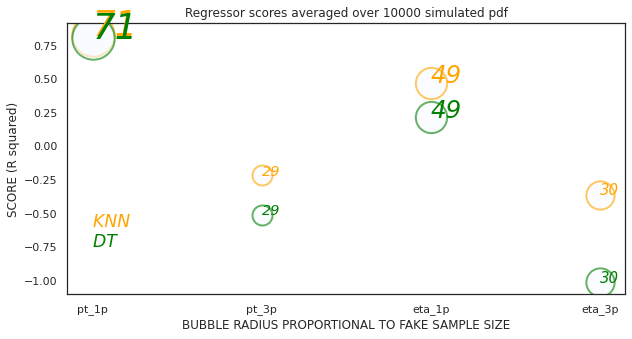

In [125]:
plt.figure(figsize=(10,5))
s=[90,20,49,40]
ss=[71,29,49,30]

for i,key in enumerate(['pt_1p','pt_3p','eta_1p','eta_3p']):
    x=np.random.rand(1)
    plt.scatter(key, knn[1][key], s=s[i]*20, c=x, cmap="Blues", alpha=0.6, edgecolors="orange", linewidth=2)#,label='KNN regressor ')
    plt.scatter(key, dt[1][key], s=s[i]*20, c=x, cmap="Blues", alpha=0.6, edgecolors="green", linewidth=2)#, label='DT regressor ')
    plt.annotate(str(ss[i]),(key,knn[1][key]),c='orange',style='italic',size=ss[i]/2)
    plt.annotate(str(ss[i]),(key,dt[1][key]),c='green',style='oblique',size=ss[i]/2)
plt.xlabel("BUBBLE RADIUS PROPORTIONAL TO FAKE SAMPLE SIZE")
plt.ylabel('SCORE (R squared)')
plt.title("Regressor scores averaged over 10000 simulated pdf")
plt.annotate('KNN ',('pt_1p',-0.6),c='orange',style='italic',size='x-large')
plt.annotate('DT ',('pt_1p',-0.75),c='green',style='italic',size='x-large')
 
plt.show()

The score of the regressor has been calculated with the R-squared metric, which can be arbitrary small and even negative. The best one can get is 1, whereasa a negative estimate means a bed performance of the regressor.

In the bubble plot is clear that when the statistic is poor the score is small, even if KNN turns out to be always better than the DT. The score is not the only feature that one should analyze to quantify the goodness of the regressor. Indeed it is important to consider the working time, as follows 

In [67]:
bins_pt,bins_eta = (np.array(selections[key][0].loc['bins','metadata']) for key in ['pt_1p','eta_3p'])
X_pt,X_eta = (((i[1:]+i[:-1])/2) for i in [bins_pt,bins_eta])
ttbar_pt, ttbar_eta = (np.array(selections[key][0].loc['curve','ttbar']) for key in ['pt_1p','eta_3p'])
total_pt,total_eta = (np.array(selections[key][0].loc['curve','ttbar'])+np.array(selections[key][0].loc['curve','fakes'])for key in ['pt_1p','eta_3p'])

In [133]:
n_simulations = [1,10,50,100,1000,10000]
knn_time_pt,dt_time_pt,knn_time_eta,dt_time_eta=(np.zeros(6) for i in range(0,4))

for h,i in enumerate(n_simulations):
    knn_time_pt[h]=Regressor('KNN',X_pt,ttbar_pt,total_pt,i,best_param_KNN(X_pt.reshape(-1,1),ttbar_pt.reshape(-1)))[2]
    dt_time_pt[h]=Regressor('DT',X_pt,ttbar_pt,total_pt,i,best_param_DT(X_pt.reshape(-1,1),ttbar_pt.reshape(-1)))[2]
    knn_time_eta[h]=Regressor('KNN',X_eta,ttbar_eta,total_eta,i,best_param_KNN(X_eta.reshape(-1,1),ttbar_eta.reshape(-1)))[2]
    dt_time_eta[h]=Regressor('DT',X_eta,ttbar_eta,total_eta,i,best_param_DT(X_eta.reshape(-1,1),ttbar_eta.reshape(-1)))[2] 

Text(0.5, 1.0, 'KNN vs DT working time')

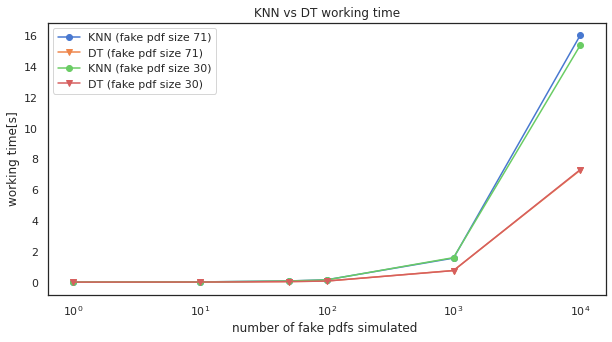

In [134]:
plt.figure(figsize=(10,5))

plt.plot(n_simulations,knn_time_pt,label='KNN (fake pdf size 71)',marker='o')
plt.plot(n_simulations,dt_time_pt,label='DT (fake pdf size 71)',marker='v')
plt.plot(n_simulations,knn_time_eta,label='KNN (fake pdf size 30)',marker='o')
plt.plot(n_simulations,dt_time_eta,label='DT (fake pdf size 30)',marker='v')


plt.legend()
plt.xscale('log')
plt.xlabel('number of fake pdfs simulated ')
plt.ylabel('working time[s]')
plt.title('KNN vs DT working time')


In the line chart it is evident that when the number of simulated pdf becomes large, the difference in time between KNN and DT increases dramatically no matter the fake sample size(for 10000 simulations the KNN working time is double that of DT). 

If one combines this information with the one of the previous plot, when the pdf we want to simulate has sufficiently large statistics, KNN regressor takes twice the time of DT to get the same score, so DT is definitely preferred.